In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

## Results location

In [3]:
import os
from pathlib import Path

# Get the current working directory
home_path = Path(os.getcwd())
hyp_folder = home_path / "results/hyp_tuning"

frog_folder = hyp_folder / "frog_1"
rooster_folder = hyp_folder / "rooster_1"

## Read similarity dist. results

In [4]:
# Tested hyperparameters
num_of_freq_bins_list = [5, 10, 20, 30, 40, 50]
num_of_time_bins_list = [5, 10, 15, 20, 25]
p_values_list = [0.2, 0.3, 0.4, 0.5, 0.6]

In [ ]:
# Saved results reference:
# [0]: spec_db
# [1]: importance
# [2]: uncertainty
# [3]: similarities <-- Analysing these results
# [4]: b_imp
# [5]: b_unc

In [ ]:
def add_new_stats_to_df(similarities, df, freq_bins, time_bins, p_val):
    # Get stats of similarities
    mean = float(torch.mean(similarities))
    median = float(torch.median(similarities))
    std = float(torch.std(similarities))
    # Range
    min = float(torch.min(similarities))
    max = float(torch.max(similarities))
    range_100 = max - min
    # 80% range
    quant_10 = float(torch.quantile(similarities, 0.1))
    quant_90 = float(torch.quantile(similarities, 0.9))
    range_80 = quant_90 - quant_10

    # Create a new row
    new_row = {"freq_bins": freq_bins, "time_bins": time_bins, "p_val": p_val,
               "mean": mean, "median": median, "std": std,
               "min": min, "max": max, "range_100": range_100,
               "quant_10": quant_10, "quant_90": quant_90, "range_80": range_80}
    # Concat row to the dataframe
    df = pd.concat([df, pd.DataFrame(new_row, index=[0])], ignore_index=True)

    return df

In [ ]:
# Creating dataframes for frog and rooster results
columns = ["freq_bins", "time_bins", "p_val",
            "mean", "median", "std",
            "min", "max", "range_100",
            "quant_10", "quant_90", "range_80"
            ]
frog_df = pd.DataFrame(columns=columns)
rooster_df = pd.DataFrame(columns=columns)

# Loop over results and save them in the dataframes
for f_num in num_of_freq_bins_list:
    for t_num in num_of_time_bins_list:
        for p_val in p_values_list:
            # Load the results
            frog_path = frog_folder / f"frog_1_{t_num}_{f_num}_{p_val}_test.pt"
            rooster_path = rooster_folder / f"rooster_1_{t_num}_{f_num}_{p_val}_test.pt"

            loaded_frog = True
            loaded_rooster = True
            try:
                frog_results = torch.load(frog_path)
                frog_similarities = frog_results[3]
            except:
                print(f"Could not load {frog_path}")
                loaded_frog = False

            try:
                rooster_results = torch.load(rooster_path)
                rooster_similarities = rooster_results[3]
            except:
                print(f"Could not load {rooster_path}")
                loaded_rooster = False
            

            # Calculate the mean, median and std
            # Append the results to the dataframes
            
            if loaded_frog:
                frog_df = add_new_stats_to_df(frog_similarities, frog_df, f_num, t_num, p_val)

            if loaded_rooster:
                rooster_df = add_new_stats_to_df(rooster_similarities, rooster_df, f_num, t_num, p_val)

In [ ]:
# Save the dataframes
frog_df.to_csv(frog_folder / "frog_results.csv")
rooster_df.to_csv(rooster_folder / "rooster_results.csv")

In [5]:
# Load data from saved dataframe
frog_df = pd.read_csv(frog_folder / "frog_results.csv")
rooster_df = pd.read_csv(rooster_folder / "rooster_results.csv")

## Correlation analysis

In [12]:
def get_selected_correlations(df, 
                              selected_cols = ["freq_bins", "time_bins", "p_val", "std", "range_80", "range_100"],
                              num_params = 3
                              ):
    # Selecting relevant columns for correlation analysis
    data_selected = df[selected_cols]

    # Calculating the correlation matrix
    correlation_matrix = data_selected.corr()

    cross_corr = correlation_matrix.iloc[0:num_params, num_params:]
    param_corr = correlation_matrix.iloc[0:num_params, 0:num_params]
    stat_corr = correlation_matrix.iloc[num_params:, num_params:]

    return cross_corr, param_corr, stat_corr

# Get the correlation matrices
frog_selected_corr, frog_hyp_corr, frog_stat_corr  = get_selected_correlations(frog_df)
rooster_selected_corr, rooster_hyp_corr, rooster_stat_corr = get_selected_correlations(rooster_df)

# Display the cross correlations
print("Frog cross correlation matrix:")
print(frog_selected_corr, end="\n\n")
print("Rooster cross correlation matrix:")
print(rooster_selected_corr, end="\n\n")

# Display the hyperparameter correlations
print("Hyperparameter correlations:")
print(frog_hyp_corr, end="\n\n")

# Display the statistic correlations
print("Frog statistic correlation matrix:")
print(frog_stat_corr, end="\n\n")
print()
print("Rooster statistic correlation matrix:")
print(rooster_stat_corr, end="\n\n")


Frog cross correlation matrix:
                std  range_80  range_100
freq_bins -0.582670 -0.576435  -0.488569
time_bins -0.559796 -0.542002  -0.569381
p_val     -0.093494 -0.042400  -0.381276

Rooster cross correlation matrix:
                std  range_80  range_100
freq_bins -0.540953 -0.523076  -0.564287
time_bins -0.529880 -0.501158  -0.652963
p_val     -0.543300 -0.578906  -0.261685

Hyperparameter correlations:
              freq_bins     time_bins         p_val
freq_bins  1.000000e+00 -6.900691e-17 -8.941445e-17
time_bins -6.900691e-17  1.000000e+00  5.625130e-17
p_val     -8.941445e-17  5.625130e-17  1.000000e+00

Frog statistic correlation matrix:
                std  range_80  range_100
std        1.000000  0.994132   0.839720
range_80   0.994132  1.000000   0.790635
range_100  0.839720  0.790635   1.000000


Rooster statistic correlation matrix:
                std  range_80  range_100
std        1.000000  0.996474   0.873755
range_80   0.996474  1.000000   0.852304
range

## Std vs p-value

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

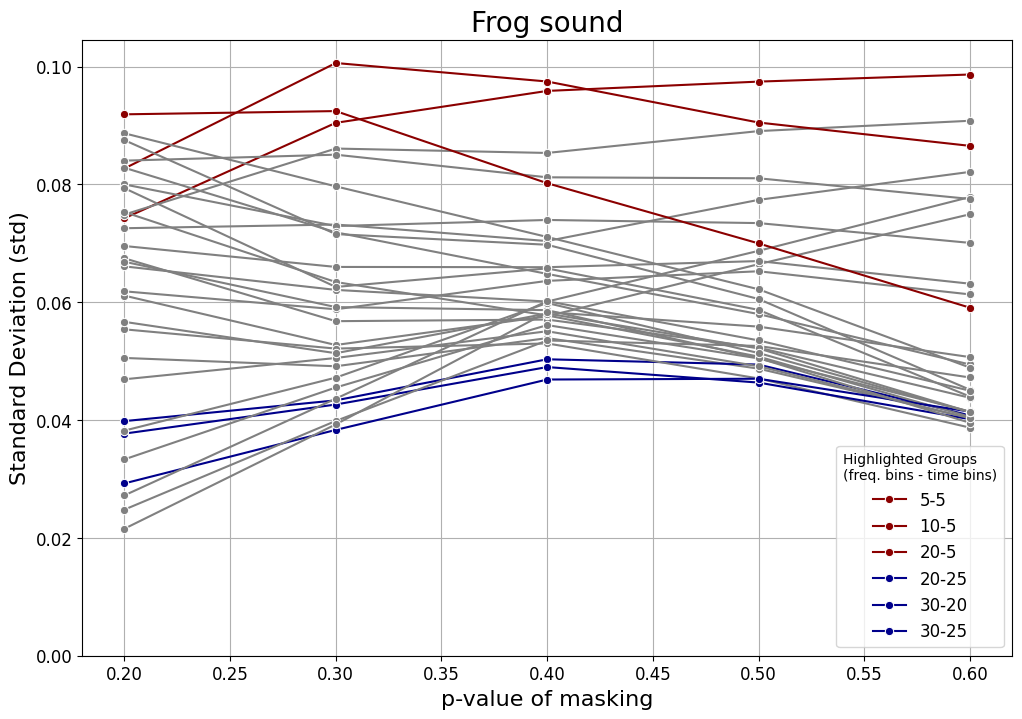

In [8]:
# Prepare the data for plotting
data_frog_plot = frog_df.copy()
data_frog_plot['f_bins_t_bins'] = data_frog_plot['freq_bins'].astype(str) + '-' + data_frog_plot['time_bins'].astype(str)

# Creating the plot

# Calculating the maximum 'std' for each 'f_bins'-'t_bins' combination
max_std_per_group = data_frog_plot.groupby('f_bins_t_bins')['std'].max().sort_values(ascending=False)
top_3_max_std_groups = max_std_per_group.head(3).index.tolist()
bottom_3_max_std_groups = max_std_per_group.tail(3).index.tolist()

# Creating the plot with top 3 and bottom 3 lines highlighted
plt.figure(figsize=(12, 8))
for group in data_frog_plot['f_bins_t_bins'].unique():
    if group in top_3_max_std_groups:
        # Highlight top 3 groups in shades of red
        sns.lineplot(x='p_val', y='std', data=data_frog_plot[data_frog_plot['f_bins_t_bins'] == group], 
                     marker='o', label=group, color='darkred')
    elif group in bottom_3_max_std_groups:
        # Highlight bottom 3 groups in shades of blue
        sns.lineplot(x='p_val', y='std', data=data_frog_plot[data_frog_plot['f_bins_t_bins'] == group], 
                     marker='o', label=group, color='darkblue')
    else:
        # Plot other groups in gray
        sns.lineplot(x='p_val', y='std', data=data_frog_plot[data_frog_plot['f_bins_t_bins'] == group], 
                     color='gray', marker='o', legend=False)

plt.ylim(bottom=0)  # Set y-axis minimum to 0
plt.title('Frog sound', fontsize=20)
plt.xlabel('p-value of masking', fontsize=16)
plt.ylabel('Standard Deviation (std)', fontsize=16)
plt.legend(title='Highlighted Groups \n(freq. bins - time bins)', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(True)
plt.show()


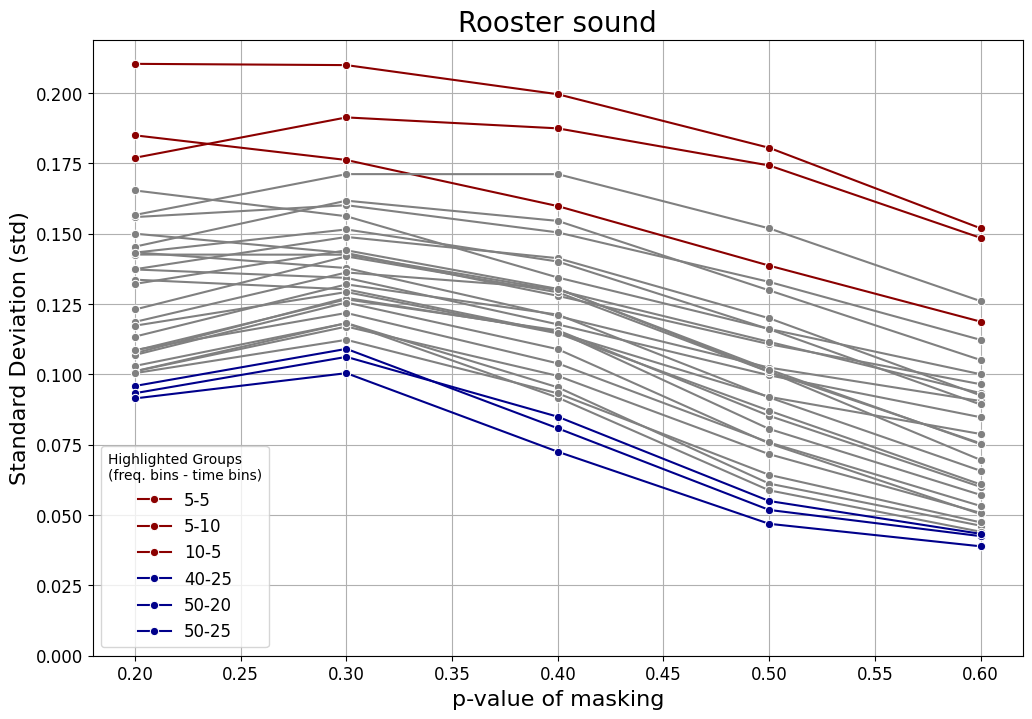

In [9]:
# Prepare the data for the rooster dataset
data_rooster_plot = rooster_df.copy()
data_rooster_plot['f_bins_t_bins'] = data_rooster_plot['freq_bins'].astype(str) + '-' + data_rooster_plot['time_bins'].astype(str)

# Calculating the maximum 'std' for each 'f_bins'-'t_bins' combination in the rooster dataset
max_std_per_group_rooster = data_rooster_plot.groupby('f_bins_t_bins')['std'].max().sort_values(ascending=False)
top_3_max_std_groups_rooster = max_std_per_group_rooster.head(3).index.tolist()
bottom_3_max_std_groups_rooster = max_std_per_group_rooster.tail(3).index.tolist()

# Creating the plot with top 3 and bottom 3 lines highlighted for the rooster dataset
plt.figure(figsize=(12, 8))
for group in data_rooster_plot['f_bins_t_bins'].unique():
    if group in top_3_max_std_groups_rooster:
        # Highlight top 3 groups in shades of red
        sns.lineplot(x='p_val', y='std', data=data_rooster_plot[data_rooster_plot['f_bins_t_bins'] == group], 
                     marker='o', label=group, color='darkred')
    elif group in bottom_3_max_std_groups_rooster:
        # Highlight bottom 3 groups in shades of blue
        sns.lineplot(x='p_val', y='std', data=data_rooster_plot[data_rooster_plot['f_bins_t_bins'] == group], 
                     marker='o', label=group, color='darkblue')
    else:
        # Plot other groups in gray
        sns.lineplot(x='p_val', y='std', data=data_rooster_plot[data_rooster_plot['f_bins_t_bins'] == group], 
                     color='gray', marker='o', legend=False)

plt.ylim(bottom=0)  # Set y-axis minimum to 0
plt.title('Rooster sound', fontsize=20)
plt.xlabel('p-value of masking', fontsize=16)
plt.ylabel('Standard Deviation (std)', fontsize=16)
plt.legend(title='Highlighted Groups \n(freq. bins - time bins)', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(True)
plt.show()


## Best hyperparameters based on std

In [11]:
# Finding the best p_val for each f_bins-t_bins combination in the frog dataset
best_p_val_per_group_frog = data_frog_plot.loc[data_frog_plot.groupby('f_bins_t_bins')['std'].idxmax()]
top_3_combinations_frog = best_p_val_per_group_frog.sort_values(by='std', ascending=False).head(3)

# Finding the best p_val for each f_bins-t_bins combination in the rooster dataset
best_p_val_per_group_rooster = data_rooster_plot.loc[data_rooster_plot.groupby('f_bins_t_bins')['std'].idxmax()]
top_3_combinations_rooster = best_p_val_per_group_rooster.sort_values(by='std', ascending=False).head(3)

top_3_combinations_frog.iloc[:, 1:], top_3_combinations_rooster.iloc[:, 1:]

(    freq_bins  time_bins  p_val      mean    median       std       min  \
 26         10          5    0.3  0.756603  0.754443  0.100622  0.452365   
 4           5          5    0.6  0.668583  0.675405  0.098668  0.398805   
 51         20          5    0.3  0.699216  0.687924  0.092461  0.443171   
 
          max  range_100  quant_10  quant_90  range_80 f_bins_t_bins  
 26  0.974074   0.521710  0.623007  0.893967  0.270960          10-5  
 4   0.926092   0.527287  0.532063  0.791283  0.259220           5-5  
 51  0.935963   0.492792  0.590272  0.832078  0.241806          20-5  ,
     freq_bins  time_bins  p_val      mean    median       std       min  \
 0           5          5    0.2  0.769145  0.844461  0.210387  0.274749   
 26         10          5    0.3  0.691137  0.706871  0.191345  0.225943   
 5           5         10    0.2  0.740894  0.744490  0.184972  0.319448   
 
          max  range_100  quant_10  quant_90  range_80 f_bins_t_bins  
 0   1.000000   0.725251  0.4464